In [1]:
import pandas as pd

# Import dataset
data = pd.read_csv('Microsoft_Stock.csv')
data.describe()

,Open,High,Low,Close,Volume
count,1511.000000,1511.000000,1511.000000,1511.000000,1.511000e+03
mean,107.385976,108.437472,106.294533,107.422091,3.019863e+07
std,56.691333,57.382276,55.977155,56.702299,1.425266e+07
min,40.340000,40.740000,39.720000,40.290000,1.016120e+05
25%,57.860000,58.060000,57.420000,57.855000,2.136213e+07
50%,93.990000,95.100000,92.920000,93.860000,2.662962e+07
75%,139.440000,140.325000,137.825000,138.965000,3.431962e+07
max,245.030000,246.130000,242.920000,244.990000,1.352271e+08


0.9982158366942122


'\nP-value from adfuller test matches graphical observation: dataset is not stationary.\nExplore options to make data stationary. The most obvious choice is to compute log differences, aka, \ndaily return.\n'

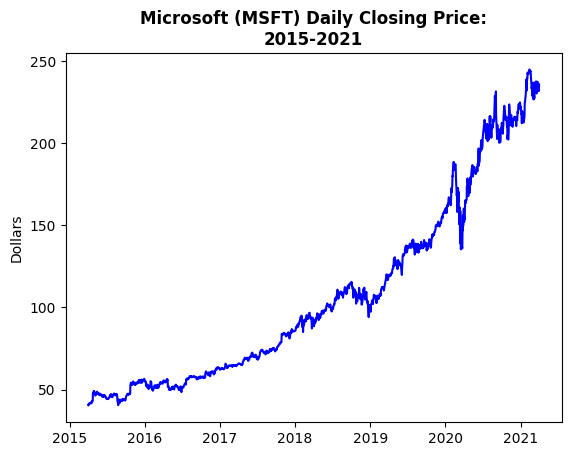

In [2]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# Change `Date` column to datetime, then plot original data. Will look at daily closing price
data['Date'] = pd.to_datetime(data['Date'])

plt.plot(data['Date'], data['Close'], color='blue')
plt.title('Microsoft (MSFT) Daily Closing Price:\n2015-2021', fontdict={'fontweight':'bold'})
plt.ylabel('Dollars')

print(adfuller(data['Close'])[1])
"""
P-value from adfuller test matches graphical observation: dataset is not stationary.
Explore options to make data stationary. The most obvious choice is to compute log differences, aka, 
daily return.
"""




1.8359205093750859e-25


'\nTaking log of data eliminates unequal variance...for the most part.\nWe can try differencing the data to see if that eliminates the non-constant mean.\n'

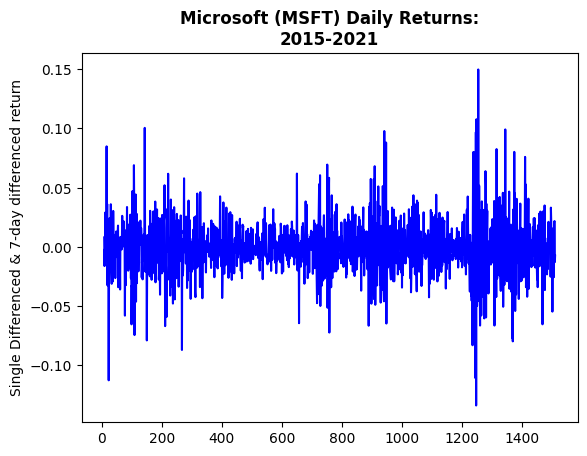

In [3]:
import numpy as np

plt.plot(np.log(data['Close']).diff().diff(7).dropna(), color='blue')
plt.title('Microsoft (MSFT) Daily Returns:\n2015-2021', fontdict={'fontweight':'bold'})
plt.ylabel('Single Differenced & 7-day differenced return')

print(adfuller(np.log(data['Close']).diff().diff(7).dropna())[1])
"""
Taking log of data eliminates unequal variance...for the most part.
We can try differencing the data to see if that eliminates the non-constant mean.
"""


"\nplot_acf(np.log(data['Close']).diff().diff(8).dropna());\nplot_pacf(np.log(data['Close']).diff().diff(8).dropna());\n"

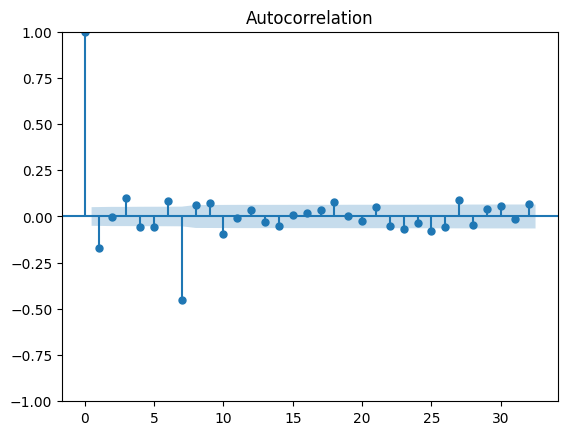

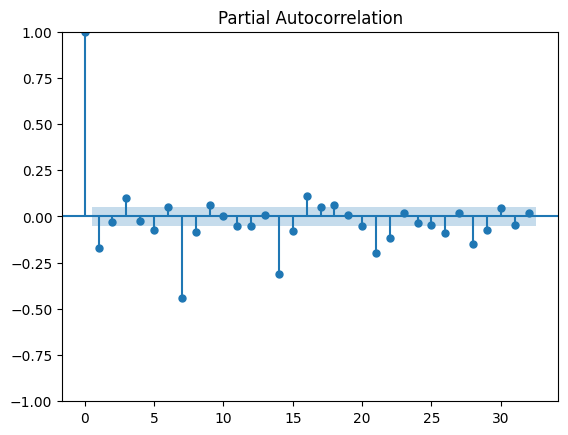

In [4]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Observe ACF/PACF plots to determine potential ARIMA models 
dailyReturns = data['Close'].diff().dropna()
plot_acf(dailyReturns.diff(7).dropna());
plot_pacf(dailyReturns.diff(7).dropna());

"""
plot_acf(np.log(data['Close']).diff().diff(8).dropna());
plot_pacf(np.log(data['Close']).diff().diff(8).dropna());
"""


## ARIMA/SARIMA models to test
1. ARIMA(1,1,1)x(0,1,1,7)
2. ARIMA(1,1,0)x(0,1,1,7)
3. ARIMA(0,1,1)x(0,1,1,7)


In [5]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from scipy.stats import shapiro
"""
Put together list of models and the parameters to test.
Input format = [p, d, q, P, D, Q, s]
"""
modelParameters = [
    [1,1,1,0,1,1,7,'ARIMA(1,1,1)x(0,1,1,7)'],
    [1,1,0,0,1,1,7,'ARIMA(1,1,0)x(0,1,1,7)'],
    [0,1,1,0,1,1,7,'ARIMA(0,1,1)x(0,1,1,7)']
]

modelResults = []

for m in modelParameters:
    mod = ARIMA(endog=np.log(data['Close']),
                order=(m[0], m[1], m[2]),
                seasonal_order=(m[3], m[4], m[5], m[6])
                ).fit()
    y_pred = np.exp(mod.fittedvalues)[8:]
    y_true = data['Close'][8:]
    aic, bic = mod.aic, mod.bic
    mae, mse, mape = mean_absolute_error(y_true=y_true, y_pred=y_pred), mean_squared_error(y_true=y_true, y_pred=y_pred), mean_absolute_percentage_error(y_true=y_true, y_pred=y_pred)
    shapiro_pvalue = shapiro(mod.resid[8:])[1]
    modelResults.append([m[7], aic, bic, mae, mse, mape, shapiro_pvalue])
    
modelResults = pd.DataFrame(modelResults, columns=['Model','AIC','BIC','MAE','MSE','MAPE','Shapiro'])
modelResults

    
    
    


,Model,AIC,BIC,MAE,MSE,MAPE,Shapiro
0,"ARIMA(1,1,1)x(0,1,1,7)",-7958.329419,-7937.068546,1.327758,5.161255,0.011620,9.093013e-28
1,"ARIMA(1,1,0)x(0,1,1,7)",-7960.321973,-7944.376318,1.327748,5.157448,0.011622,1.039589e-27
2,"ARIMA(0,1,1)x(0,1,1,7)",-7957.955652,-7942.009997,1.327781,5.186043,0.011612,5.536212e-28


                                     SARIMAX Results                                     
Dep. Variable:                             Close   No. Observations:                 1511
Model:             ARIMA(1, 1, 0)x(0, 1, [1], 7)   Log Likelihood                3983.161
Date:                           Mon, 09 Sep 2024   AIC                          -7960.322
Time:                                   17:58:54   BIC                          -7944.376
Sample:                                        0   HQIC                         -7954.382
                                          - 1511                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2138      0.012    -18.058      0.000      -0.237      -0.191
ma.S.L7       -0.9814      0.005   -178.962

"\nplt.plot(arima_model.resid[8:])     # spike around x=1250 likely causing normality to fail\nplt.title(r'$SARIMA(1,1,0)x(0,1,1)_{7}$ Residuals')\n\n#sm.qqplot(arima_model.resid[1:])\nplot_acf(arima_model.resid[8:],title=r'Autocorrelation: $SARIMA(1,1,0)x(0,1,1)_{7}$ Residuals');\nplot_pacf(arima_model.resid[8:],title=r'Partial Autocorrelation: $SARIMA(1,1,0)x(0,1,1)_{7}$ Residuals');\n\nplt.hist(arima_model.resid[8:])\n"

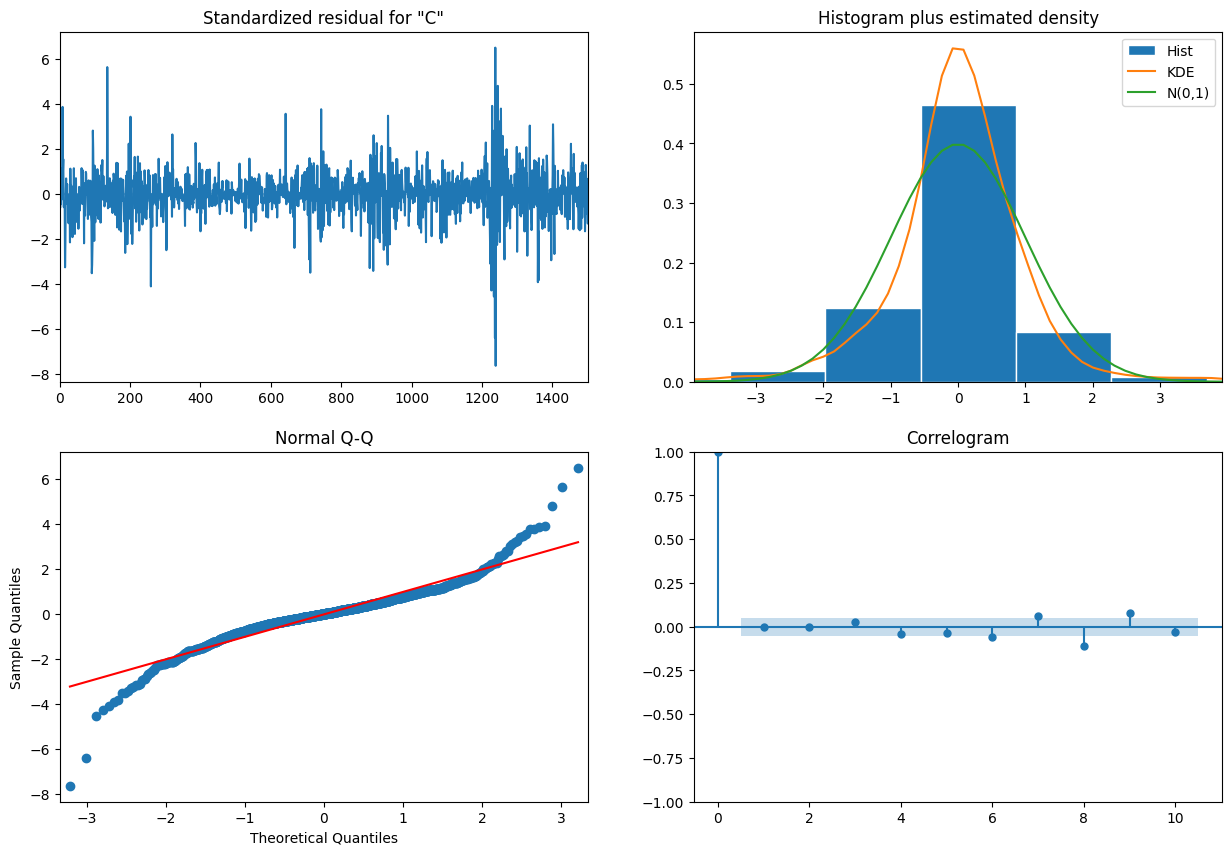

In [6]:
# ARIMA(1,1,0)x(0,1,1,7)
arima_model = ARIMA(endog=np.log(data['Close']),
                    order=(1,1,0),
                    seasonal_order=(0,1,1,7)).fit()

print(arima_model.summary())

arima_model.plot_diagnostics(figsize=(15,10))
"""
plt.plot(arima_model.resid[8:])     # spike around x=1250 likely causing normality to fail
plt.title(r'$SARIMA(1,1,0)x(0,1,1)_{7}$ Residuals')

#sm.qqplot(arima_model.resid[1:])
plot_acf(arima_model.resid[8:],title=r'Autocorrelation: $SARIMA(1,1,0)x(0,1,1)_{7}$ Residuals');
plot_pacf(arima_model.resid[8:],title=r'Partial Autocorrelation: $SARIMA(1,1,0)x(0,1,1)_{7}$ Residuals');

plt.hist(arima_model.resid[8:])
"""



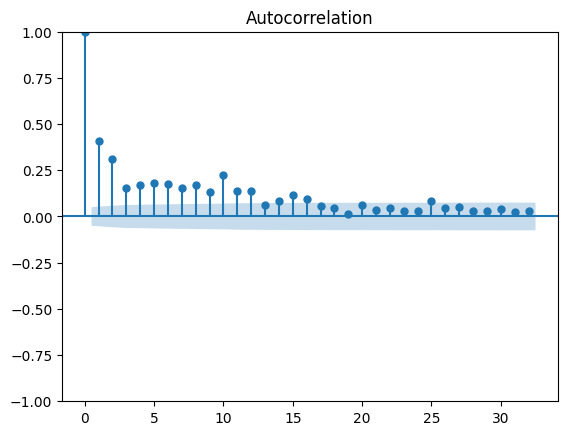

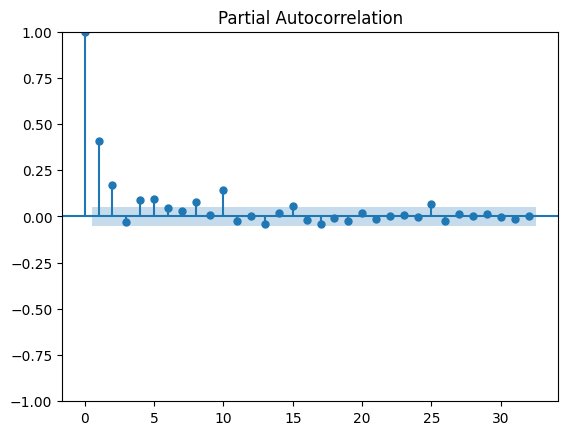

In [7]:
from arch import arch_model

# squared residuals. If these display spikes/decay, likely that GARCH can be applied to some degree
plot_acf(arima_model.resid[8:]**2);
plot_pacf(arima_model.resid[8:]**2);


Iteration:      1,   Func. Count:      5,   Neg. LLF: -4169.480862624912
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4169.480864847455
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 1
                     Zero Mean - GJR-GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                  GJR-GARCH   Log-Likelihood:                4169.48
Distribution:                  Normal   AIC:                          -8330.96
Method:            Maximum Likelihood   BIC:                          -8309.70
                                        No. Observations:                 1503
Date:                Mon, Sep 09 2024   Df Residuals:                     1503
Time:                        17:58:56   Df Model:                            0
         

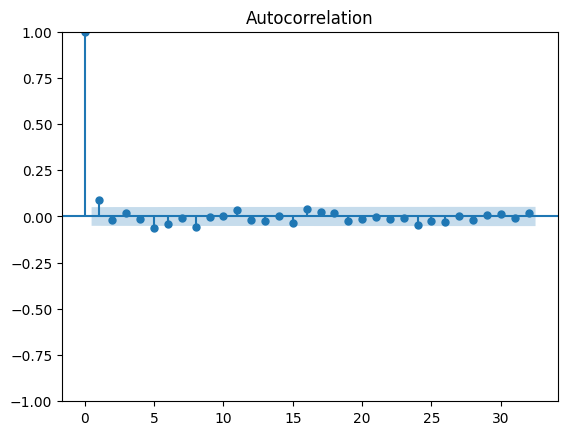

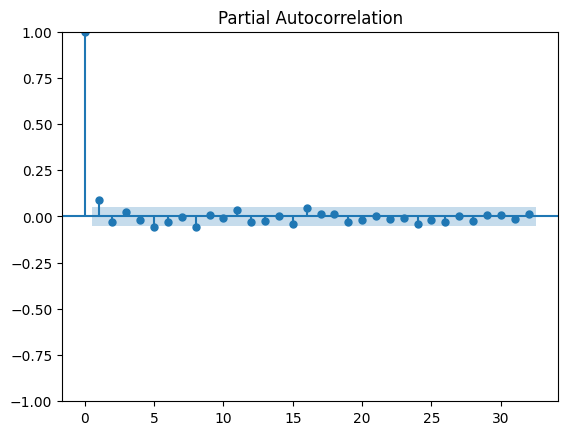

In [8]:
# Create garch model. p=q=o=1 performed the best of tested parameters
garch_model = arch_model(arima_model.resid[8:], mean='Zero', vol='GARCH', p=1, o=1, q=1, rescale=False).fit()
print(garch_model.summary())

standardized_garch_residuals = pd.Series(garch_model.resid / garch_model.conditional_volatility)
plot_acf(standardized_garch_residuals);
plot_pacf(standardized_garch_residuals);




Text(0.5, 1.0, 'GARCH(1,1) Standardized Residuals')

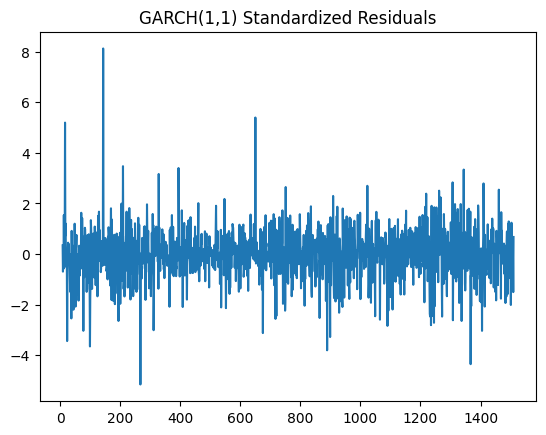

In [9]:
# Plot GARCH standardized residuals
plt.plot(standardized_garch_residuals)
plt.title('GARCH(1,1) Standardized Residuals')

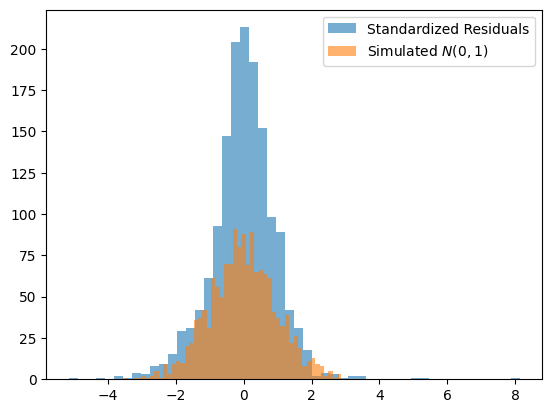

In [10]:
# Plot histogram of GARCH standardized residuals
plt.hist(standardized_garch_residuals, bins=50, alpha=0.6, label='Standardized Residuals')
plt.hist(np.random.standard_normal(size=1500), bins=50, alpha=0.6, label=r'Simulated $N(0,1)$')
plt.legend()


ARIMA and ARIMA/GARCH combination fails to pass diagnostic checks. Serial correlation is not present within residuals, however, residuals do not present as normally distributed. This is likely due to high variance at certain points in the market fluctuation (e.g. early 2020)

We will now explore another option: deep learning models. Create separate set of tensorflow neural network models. 4 different types of models will initially be explored:
1. MLP (multilayer perceptron)
2. LSTM
3. Simple RNN
4. Gated Recurrent Unit (GRU)

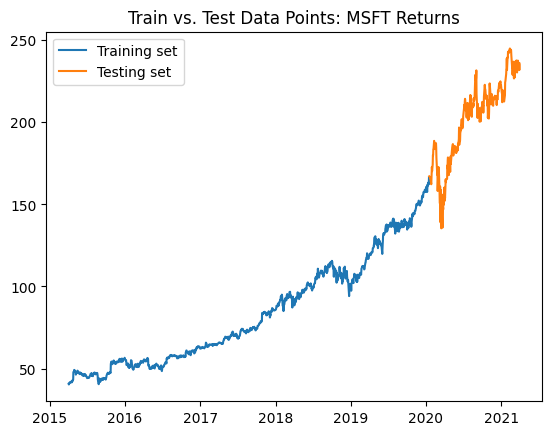

In [11]:
# Set train data to first 80% of returns, test data to remaining 20%
from sklearn.preprocessing import MinMaxScaler

train_split = 0.8
split_point = int(len(data)*train_split)

train_data, test_data = np.reshape(data['Close'][:split_point], (-1,1)), np.reshape(data['Close'][split_point:], (-1,1))

# Plot train/test to visually see proportion. It's evident that the high variance
# at start of test dataset will be tough for any model to navigate.
plt.plot(data['Date'][:split_point], train_data, label='Training set')
plt.plot(data['Date'][split_point:], test_data, label='Testing set')
plt.legend()
plt.title('Train vs. Test Data Points: MSFT Returns')


scaler = MinMaxScaler()
scaled_train_data = scaler.fit_transform(train_data)
scaled_test_data = scaler.transform(test_data)


In [12]:
"""
Need to split up test dataset into input "variables" and output. Create a function to perform this split.
Given that an ARIMA-based approach exhibited signs of weekly autocorrelation, we will be sure to have a window
of at least 14 days. We could explore upwards of 30 days to account for potential monthly autocorrelation,
although that was not explored in the initial approach.
"""
def prepare_model_data(window, train, test):
    X_train = []
    X_test = []
    y_train = []
    y_test = []
    for i in range(window, len(train)):
        X_train.append(train[i-window:i])
        y_train.append(train[i])
    for j in range(window, len(test)):
        X_test.append(test[j-window:j])
        y_test.append(test[j])
    return np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test) 

window = 30
X_train, X_test, y_train, y_test = prepare_model_data(window=window, train=scaled_train_data, test=scaled_test_data)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_test = np.reshape(y_test, (y_test.shape[0], 1))


In [13]:
import setuptools.dist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, SimpleRNN, GRU
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria for models
callback = EarlyStopping(
    monitor='val_loss',
    min_delta=0.0005,
    patience=50,
    restore_best_weights=True
)


# Multi layer perceptron NN. Inputs are not necessarily related in terms of time-steps, but rather,
# they are considered variables for a regression type problem.
MLP_model = Sequential()
MLP_model.add(Input(shape=(window,)))
MLP_model.add(Dense(100, activation='relu'))
MLP_model.add(Dropout(0.4))
MLP_model.add(Dense(1))
MLP_model.compile(optimizer='adam', loss='mse', metrics=['mse'])
MLP_history = MLP_model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=3, epochs=300, callbacks=[callback])




2024-09-09 17:59:01.644885: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/300
393/393 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0684 - mse: 0.0684 - val_loss: 0.0127 - val_mse: 0.0127
Epoch 2/300
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0073 - mse: 0.0073 - val_loss: 0.0101 - val_mse: 0.0101
Epoch 3/300
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0059 - mse: 0.0059 - val_loss: 0.0074 - val_mse: 0.0074
Epoch 4/300
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0056 - mse: 0.0056 - val_loss: 0.0050 - val_mse: 0.0050
Epoch 5/300
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0142 - val_mse: 0.0142
Epoch 6/300
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0061 - mse: 0.0061 - val_loss: 0.0124 - val_mse: 0.0124
Epoch 7/300
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0044 - mse: 0.0044 - val_loss: 0.0408 - val_mse: 0.0408
Epoch 8/300
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0042 - mse: 0.0042 - val_loss: 0.0232 - val_mse: 0.0232
Epoch 9/300
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/

In [14]:
LSTM_model = Sequential()
LSTM_model.add(Input(shape=(X_train.shape[1],1)))
LSTM_model.add(LSTM(100, return_sequences=True))
LSTM_model.add(LSTM(100, return_sequences=False))
LSTM_model.add(Dense(100, activation='relu'))
LSTM_model.add(Dropout(0.4))
LSTM_model.add(Dense(1))
LSTM_model.compile(optimizer='adam',loss='mse', metrics=['mse'])
LSTM_history = LSTM_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=300, callbacks=[callback])



Epoch 1/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - loss: 0.0426 - mse: 0.0426 - val_loss: 0.0062 - val_mse: 0.0062
Epoch 2/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0053 - mse: 0.0053 - val_loss: 0.0078 - val_mse: 0.0078
Epoch 3/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0042 - mse: 0.0042 - val_loss: 0.0358 - val_mse: 0.0358
Epoch 4/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0050 - mse: 0.0050 - val_loss: 0.0091 - val_mse: 0.0091
Epoch 5/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0050 - mse: 0.0050 - val_loss: 0.0037 - val_mse: 0.0037
Epoch 6/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0046 - mse: 0.0046 - val_loss: 0.0266 - val_mse: 0.0266
Epoch 7/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0044 - mse: 0.0044 - val_loss: 0.0207 - val_mse: 0.0207
Epoch 8/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 9/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - lo

In [15]:
RNN_model = Sequential()
RNN_model.add(Input(shape=(X_train.shape[1],1)))
RNN_model.add(SimpleRNN(100, activation='tanh', return_sequences=True))
RNN_model.add(SimpleRNN(100, activation='tanh', return_sequences=False))
RNN_model.add(Dense(100, activation='relu'))
RNN_model.add(Dropout(0.4))
RNN_model.add(Dense(1))
RNN_model.compile(optimizer='adam', loss='mse', metrics=['mse'])
RNN_history = RNN_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=300, callbacks=[callback])

Epoch 1/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.3573 - mse: 0.3573 - val_loss: 0.1214 - val_mse: 0.1214
Epoch 2/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0087 - mse: 0.0087 - val_loss: 0.1204 - val_mse: 0.1204
Epoch 3/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0078 - mse: 0.0078 - val_loss: 0.0647 - val_mse: 0.0647
Epoch 4/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0063 - mse: 0.0063 - val_loss: 0.1272 - val_mse: 0.1272
Epoch 5/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0069 - mse: 0.0069 - val_loss: 0.0476 - val_mse: 0.0476
Epoch 6/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0070 - mse: 0.0070 - val_loss: 0.0437 - val_mse: 0.0437
Epoch 7/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0066 - mse: 0.0066 - val_loss: 0.0493 - val_mse: 0.0493
Epoch 8/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0059 - mse: 0.0059 - val_loss: 0.0626 - val_mse: 0.0626
Epoch 9/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - lo

In [16]:
GRU_model = Sequential()
GRU_model.add(Input(shape=(X_train.shape[1],1)))
GRU_model.add(GRU(100, return_sequences=True, activation='tanh'))
GRU_model.add(GRU(100, return_sequences=False, activation='tanh'))
GRU_model.add(Dense(100, activation='relu'))
GRU_model.add(Dropout(0.4))
GRU_model.add(Dense(1))
GRU_model.compile(optimizer='adam', loss='mse', metrics=['mse'])
GRU_history = GRU_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=300, callbacks=[callback])


Epoch 1/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.0544 - mse: 0.0544 - val_loss: 0.0046 - val_mse: 0.0046
Epoch 2/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0054 - mse: 0.0054 - val_loss: 0.0039 - val_mse: 0.0039
Epoch 3/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0046 - mse: 0.0046 - val_loss: 0.0071 - val_mse: 0.0071
Epoch 4/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0045 - mse: 0.0045 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 5/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0031 - mse: 0.0031 - val_loss: 0.0070 - val_mse: 0.0070
Epoch 6/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0028 - val_mse: 0.0028
Epoch 7/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0029 - val_mse: 0.0029
Epoch 8/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0062 - val_mse: 0.0062
Epoch 9/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - lo

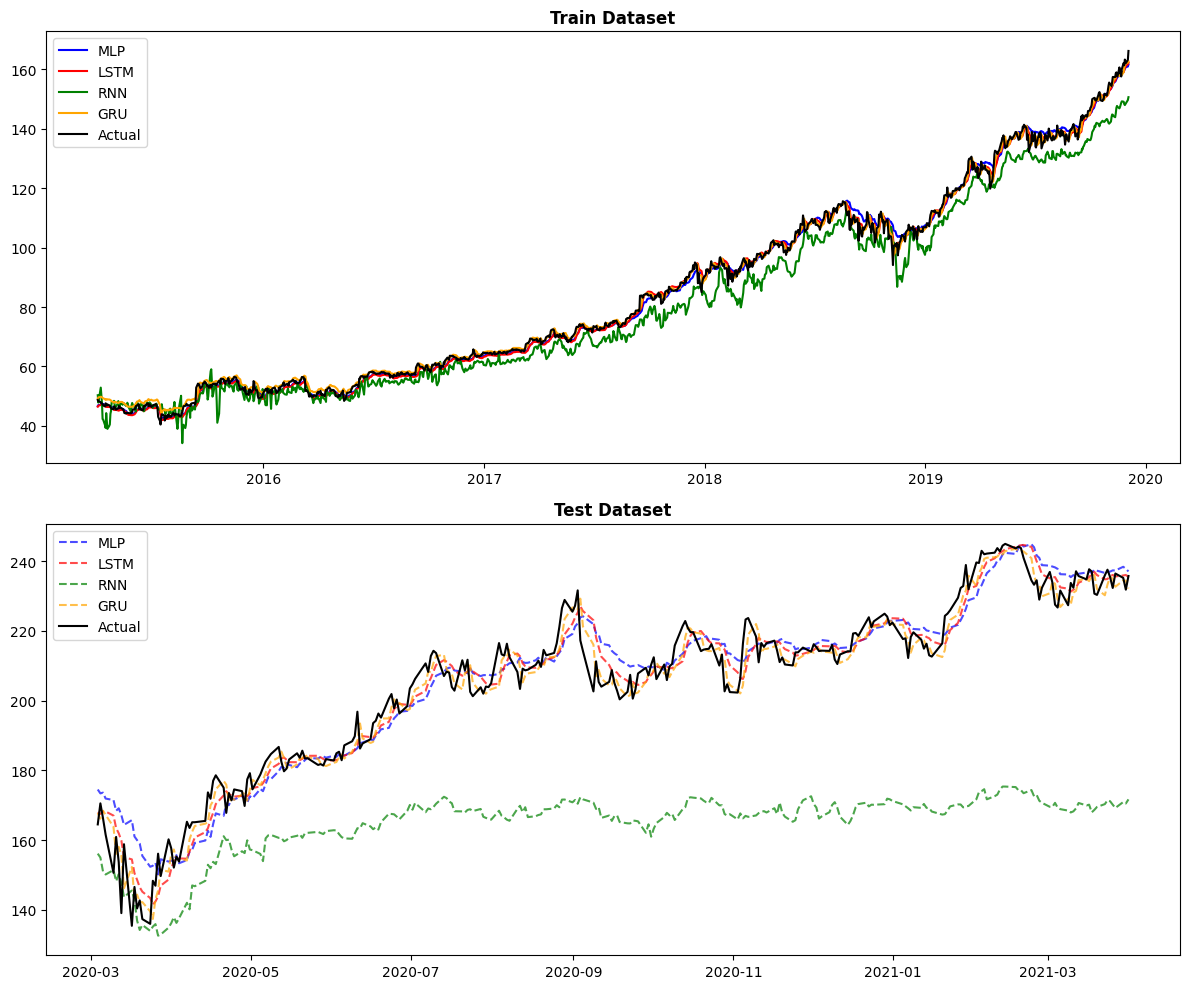

In [17]:
fig, axs = plt.subplots(ncols=1, nrows=2, figsize=(12,10))

# Plot fitted data points against actual values
axs[0].plot(data['Date'][:len(X_train)], scaler.inverse_transform(MLP_model.predict(X_train, verbose=False)), color='blue', label='MLP')
axs[0].plot(data['Date'][:len(X_train)], scaler.inverse_transform(LSTM_model.predict(X_train, verbose=False)), color='red', label='LSTM')
axs[0].plot(data['Date'][:len(X_train)], scaler.inverse_transform(RNN_model.predict(X_train, verbose=False)), color='green', label='RNN')
axs[0].plot(data['Date'][:len(X_train)], scaler.inverse_transform(GRU_model.predict(X_train, verbose=False)), color='orange', label='GRU')
axs[0].plot(data['Date'][:len(X_train)], scaler.inverse_transform(y_train), color='black', label='Actual')
axs[0].legend()
# Plot predicted data points against actual (test) values
axs[0].set_title('Train Dataset', fontdict={'fontweight':'bold'})
axs[1].plot(data['Date'][-len(X_test):], scaler.inverse_transform(MLP_model.predict(X_test, verbose=False)), color='blue', label='MLP', alpha=0.7, linestyle='--')
axs[1].plot(data['Date'][-len(X_test):], scaler.inverse_transform(LSTM_model.predict(X_test, verbose=False)), color='red', label='LSTM', alpha=0.7, linestyle='--')
axs[1].plot(data['Date'][-len(X_test):], scaler.inverse_transform(RNN_model.predict(X_test, verbose=False)), color='green', label='RNN', alpha=0.7, linestyle='--')
axs[1].plot(data['Date'][-len(X_test):], scaler.inverse_transform(GRU_model.predict(X_test, verbose=False)), color='orange', label='GRU', alpha=0.7, linestyle='--')
axs[1].plot(data['Date'][-len(X_test):], scaler.inverse_transform(y_test), color='black', label='Actual')
axs[1].legend()
axs[1].set_title('Test Dataset', fontdict={'fontweight':'bold'})

fig.tight_layout()




In [18]:
# Print metrics for each model
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

print('~~~~~~~~~~ Metrics ~~~~~~~~~~\n')
print('========== MLP ==========')
print(f'\tMAE: {mean_absolute_error(y_pred=scaler.inverse_transform(MLP_model.predict(X_train, verbose=False)), y_true=scaler.inverse_transform(y_train))}')
print(f'\tMSE: {mean_squared_error(y_pred=scaler.inverse_transform(MLP_model.predict(X_train, verbose=False)), y_true=scaler.inverse_transform(y_train))}')
print(f'\tMAPE: {mean_absolute_percentage_error(y_pred=scaler.inverse_transform(MLP_model.predict(X_train, verbose=False)), y_true=scaler.inverse_transform(y_train))}')
print('========== LSTM ==========')
print(f'\tMAE: {mean_absolute_error(y_pred=scaler.inverse_transform(LSTM_model.predict(X_train, verbose=False)), y_true=scaler.inverse_transform(y_train))}')
print(f'\tMSE: {mean_squared_error(y_pred=scaler.inverse_transform(LSTM_model.predict(X_train, verbose=False)), y_true=scaler.inverse_transform(y_train))}')
print(f'\tMAPE: {mean_absolute_percentage_error(y_pred=scaler.inverse_transform(LSTM_model.predict(X_train, verbose=False)), y_true=scaler.inverse_transform(y_train))}')
print('========== RNN ==========')
print(f'\tMAE: {mean_absolute_error(y_pred=scaler.inverse_transform(RNN_model.predict(X_train, verbose=False)), y_true=scaler.inverse_transform(y_train))}')
print(f'\tMSE: {mean_squared_error(y_pred=scaler.inverse_transform(RNN_model.predict(X_train, verbose=False)), y_true=scaler.inverse_transform(y_train))}')
print(f'\tMAPE: {mean_absolute_percentage_error(y_pred=scaler.inverse_transform(RNN_model.predict(X_train, verbose=False)), y_true=scaler.inverse_transform(y_train))}')
print('========== GRU ==========')
print(f'\tMAE: {mean_absolute_error(y_pred=scaler.inverse_transform(GRU_model.predict(X_train, verbose=False)), y_true=scaler.inverse_transform(y_train))}')
print(f'\tMSE: {mean_squared_error(y_pred=scaler.inverse_transform(GRU_model.predict(X_train, verbose=False)), y_true=scaler.inverse_transform(y_train))}')
print(f'\tMAPE: {mean_absolute_percentage_error(y_pred=scaler.inverse_transform(GRU_model.predict(X_train, verbose=False)), y_true=scaler.inverse_transform(y_train))}')



~~~~~~~~~~ Metrics ~~~~~~~~~~

========== MLP ==========
	MAE: 1.3536140434122654
	MSE: 3.738987475339615
	MAPE: 0.01627294156500667
========== LSTM ==========
	MAE: 1.3001875765011952
	MSE: 2.9266623060574277
	MAPE: 0.01658110218128249
========== RNN ==========
	MAE: 4.843114368199087
	MSE: 33.650485313862205
	MAPE: 0.05565880081332834
========== GRU ==========
	MAE: 1.1507277591362064
	MSE: 2.3286152443495665
	MAPE: 0.015756369028240565


Gated Recurrent Unit model performs the best, followed by the Long Short Term Memory model. The Multilayer perceptron model performs decent, while the recurrent neural network consistently underestimates closing stock price throughout the training and testing dataset. The GRU model could potentially see improvements with steps such as adding additional GRU/Dense layers, adding additional units to prexisting layers, or implementing another callback which adjusts learning rate upon a validation loss plateau. 